In [11]:
!pip -q install "qiskit>=1.0" "qiskit-aer>=0.14" pandas

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import os, json, math, random, time
import numpy as np
import pandas as pd

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, SparsePauliOp

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_aer.noise.errors import depolarizing_error, pauli_error, amplitude_damping_error

from qiskit import qpy
import io
import base64

# =========================
# 재현성(시드 고정)
# =========================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# =========================
# 저장 경로
# =========================
OUT_DIR = "/content/drive/MyDrive/qem_dataset"
os.makedirs(OUT_DIR, exist_ok=True)

OUT_CSV = os.path.join(OUT_DIR, "dataset_raw.csv")
OUT_META = os.path.join(OUT_DIR, "run_meta.json")

print("OUT_DIR:", OUT_DIR)


OUT_DIR: /content/drive/MyDrive/qem_dataset


In [14]:
GATE_POOL_1Q = ["rx", "ry", "rz", "x", "y", "z"]
GATE_POOL_2Q = ["cx"]

def random_2q_circuit(depth: int, p_cx: float = 0.25) -> QuantumCircuit:
    """
    depth 만큼 랜덤하게 게이트를 쌓는 2-qubit 회로 생성
    - p_cx 확률로 CX, 나머지는 1-qubit gate
    - Rx/Ry/Rz는 angle ~ Uniform(0, 2π)
    """
    qc = QuantumCircuit(2)

    for _ in range(depth):
        use_cx = (random.random() < p_cx)
        if use_cx:
            # control/target 랜덤
            if random.random() < 0.5:
                qc.cx(0, 1)
            else:
                qc.cx(1, 0)
        else:
            g = random.choice(GATE_POOL_1Q)
            q = random.choice([0, 1])

            if g in ["rx", "ry", "rz"]:
                theta = random.uniform(0, 2 * math.pi)
                getattr(qc, g)(theta, q)
            else:
                getattr(qc, g)(q)

    return qc

In [15]:
NOISE_CLASSES = ["noiseless", "pauli", "depol", "amp_damp"]

def sample_noise_params(noise_class: str):
    """
    노이즈 강도 샘플링 (원하는 범위로 조절 가능)
    - depol: p in [0.001, 0.02]
    - pauli: p in [0.001, 0.02] (X/Y/Z 균등)
    - amp_damp: gamma in [0.001, 0.05]
    """
    if noise_class == "depol":
        p = random.uniform(0.001, 0.02)
        return {"p": p}
    if noise_class == "pauli":
        p = random.uniform(0.001, 0.02)
        # X/Y/Z 균등, I는 1-p
        return {"px": p/3, "py": p/3, "pz": p/3}
    if noise_class == "amp_damp":
        gamma = random.uniform(0.001, 0.05)
        return {"gamma": gamma}
    return {}  # noiseless

def build_noise_model(noise_class: str, params: dict) -> NoiseModel:
    """
    Qiskit Aer NoiseModel 생성.
    간단/재현성 좋게: 주로 1-qubit 게이트에 노이즈를 붙이고,
    CX에는 depol일 때만 2-qubit depolarizing을 약하게 추가(옵션).
    """
    nm = NoiseModel()

    oneq_gates = ["rx", "ry", "rz", "x", "y", "z"]
    twoq_gates = ["cx"]

    if noise_class == "noiseless":
        return nm

    if noise_class == "depol":
        p = params["p"]
        err1 = depolarizing_error(p, 1)
        # 2-qubit은 보통 더 약/강하게 설정 가능. 여기선 예시로 p2=2p (원하면 바꿔)
        err2 = depolarizing_error(min(1.0, 2*p), 2)

        for g in oneq_gates:
            nm.add_all_qubit_quantum_error(err1, g)
        nm.add_all_qubit_quantum_error(err2, "cx")
        return nm

    if noise_class == "pauli":
        px, py, pz = params["px"], params["py"], params["pz"]
        pi = max(0.0, 1.0 - (px + py + pz))
        err1 = pauli_error([("X", px), ("Y", py), ("Z", pz), ("I", pi)])

        for g in oneq_gates:
            nm.add_all_qubit_quantum_error(err1, g)
        return nm

    if noise_class == "amp_damp":
        gamma = params["gamma"]
        err1 = amplitude_damping_error(gamma)

        for g in oneq_gates:
            nm.add_all_qubit_quantum_error(err1, g)
        return nm

    raise ValueError("Unknown noise_class")

In [16]:
ZZ = SparsePauliOp.from_list([("ZZ", 1.0)])

def compute_y_true_expectation(qc_no_measure: QuantumCircuit) -> float:
    """
    noiseless 기대값 y_true = <ZZ>
    - 측정이 없는 회로를 statevector로 시뮬레이션 후 expectation 계산
    """
    sv = Statevector.from_instruction(qc_no_measure)
    val = np.real(sv.expectation_value(ZZ))
    return float(val)

In [17]:
def run_noisy_counts(qc_with_measure: QuantumCircuit, noise_model: NoiseModel, shots: int = 4096) -> dict:
    """
    AerSimulator로 noisy shots 실행 후 counts(dict) 반환
    """
    sim = AerSimulator(noise_model=noise_model)
    job = sim.run(qc_with_measure, shots=shots)
    result = job.result()
    counts = result.get_counts(0)
    # counts 예: {'00': 1024, '01': 980, ...}
    return counts

In [18]:
def zz_from_counts(counts: dict) -> float:
    shots = sum(counts.values())
    return (
        counts.get("00", 0)
      - counts.get("01", 0)
      - counts.get("10", 0)
      + counts.get("11", 0)
    ) / shots

In [19]:
def make_dataset(
    N: int = 5600,
    shots: int = 4096,
    save_every: int = 200,
    p_cx: float = 0.25,
):
    """
    (1) 회로 생성 -> (2) 노이즈 샘플링 -> (3) y_true 계산 -> (4) noisy counts 생성
    결과는 OUT_CSV에 append 저장.
    """

    # 이미 저장된 CSV가 있으면 이어서 생성(런타임 끊겨도 이어가기)
    if os.path.exists(OUT_CSV):
        prev = pd.read_csv(OUT_CSV)
        start_idx = int(prev["circuit_id"].max()) + 1 if len(prev) > 0 else 0
        print(f"[Resume] Existing rows={len(prev)}, start_idx={start_idx}")
    else:
        start_idx = 0
        print("[New] Start from 0")

    rows_buffer = []
    t0 = time.time()

    for cid in range(start_idx, N):
        depth = random.randint(1, 30)

        # (1) circuit 만들기 (측정 없는 버전)
        qc = random_2q_circuit(depth=depth, p_cx=p_cx)

        # (3) y_true (측정 없는 상태에서 계산)
        y_true = compute_y_true_expectation(qc)

        # noisy 실행용 측정 회로 복사 후 measure_all 추가
        qc_m = qc.copy()
        qc_m.measure_all()

        # (2) 노이즈 클래스/강도 샘플링
        noise_class = random.choice(NOISE_CLASSES)
        params = sample_noise_params(noise_class)
        nm = build_noise_model(noise_class, params)

        # (4) noisy counts 얻기
        counts = run_noisy_counts(qc_m, nm, shots=shots)

        zz_noisy = zz_from_counts(counts)

        # QuantumCircuit -> QPY(binary) -> base64(str)
        buf = io.BytesIO()
        qpy.dump(qc, buf)
        qpy_b64 = base64.b64encode(buf.getvalue()).decode("utf-8")


        # 저장 레코드(최소 필드)
        rows_buffer.append({
            "circuit_id": cid,
            "depth": depth,
            "noise_class": noise_class,
            "noise_params": json.dumps(params, ensure_ascii=False),
            "shots": shots,
            "y_true_zz": y_true,
            "zz_noisy": zz_noisy,
            "qpy": qpy_b64,
            "counts": json.dumps(counts),   # dict를 문자열로 저장
        })

        # 중간 저장
        if (cid + 1) % save_every == 0 or (cid + 1) == N:
            df = pd.DataFrame(rows_buffer)
            header = not os.path.exists(OUT_CSV)
            df.to_csv(OUT_CSV, mode="a", header=header, index=False)

            rows_buffer = []
            elapsed = time.time() - t0
            print(f"[Saved] up to circuit_id={cid} | elapsed={elapsed:.1f}s | file={OUT_CSV}")

    # 메타 저장
    meta = {
        "N": N,
        "shots": shots,
        "save_every": save_every,
        "p_cx": p_cx,
        "seed": SEED,
        "created_at": time.strftime("%Y-%m-%d %H:%M:%S"),
        "out_csv": OUT_CSV,
    }
    with open(OUT_META, "w", encoding="utf-8") as f:
        json.dump(meta, f, ensure_ascii=False, indent=2)

    print("Done. Meta saved:", OUT_META)

In [20]:
# 본 실험
make_dataset(N=5600, shots=4096, save_every=200)

[New] Start from 0
[Saved] up to circuit_id=199 | elapsed=3.1s | file=/content/drive/MyDrive/qem_dataset/dataset_raw.csv
[Saved] up to circuit_id=399 | elapsed=5.5s | file=/content/drive/MyDrive/qem_dataset/dataset_raw.csv
[Saved] up to circuit_id=599 | elapsed=13.7s | file=/content/drive/MyDrive/qem_dataset/dataset_raw.csv
[Saved] up to circuit_id=799 | elapsed=19.3s | file=/content/drive/MyDrive/qem_dataset/dataset_raw.csv
[Saved] up to circuit_id=999 | elapsed=22.7s | file=/content/drive/MyDrive/qem_dataset/dataset_raw.csv
[Saved] up to circuit_id=1199 | elapsed=25.9s | file=/content/drive/MyDrive/qem_dataset/dataset_raw.csv
[Saved] up to circuit_id=1399 | elapsed=28.3s | file=/content/drive/MyDrive/qem_dataset/dataset_raw.csv
[Saved] up to circuit_id=1599 | elapsed=30.6s | file=/content/drive/MyDrive/qem_dataset/dataset_raw.csv
[Saved] up to circuit_id=1799 | elapsed=33.1s | file=/content/drive/MyDrive/qem_dataset/dataset_raw.csv
[Saved] up to circuit_id=1999 | elapsed=36.5s | file

In [21]:
# =========================================================
# Regression-only ML-QEM (paper-style features) + baseline
# - No classification
# - Feature: measurement (per-bitstring) + mean/var + gate features + depth
# - Compare vs baseline(no mitigation), means_model, feature_model
# =========================================================

import os, json, base64, io
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from qiskit import qpy

# -------------------------
# 0) Reproducibility
# -------------------------
def set_seed(seed: int = 42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# -------------------------
# 1) counts -> feature
# -------------------------
BITSTR_2Q = ["00", "01", "10", "11"]

def counts_to_prob_vec(counts: dict, bit_list=BITSTR_2Q) -> np.ndarray:
    shots = max(1, sum(counts.values()))
    return np.array([counts.get(b, 0) / shots for b in bit_list], dtype=np.float32)

def mean_var_from_counts_intmap(counts: dict) -> tuple[float, float]:
    shots = max(1, sum(counts.values()))
    mu, e2 = 0.0, 0.0
    for b, c in counts.items():
        v = int(b, 2)
        p = c / shots
        mu += v * p
        e2 += (v ** 2) * p
    return float(mu), float(e2 - mu ** 2)

# -------------------------
# 2) qpy -> gate features
# -------------------------
GATE_LIST = ["rx", "ry", "rz", "x", "y", "z", "cx"]

def qpy_b64_to_circuit(qpy_b64: str):
    raw = base64.b64decode(qpy_b64.encode("utf-8"))
    buf = io.BytesIO(raw)
    circuits = qpy.load(buf)
    return circuits[0]

def gate_features(qc, gate_list=GATE_LIST, mode="count") -> np.ndarray:
    counts = {g: 0 for g in gate_list}
    for inst, qargs, cargs in qc.data:
        if inst.name in counts:
            counts[inst.name] += 1
    vec = np.array([counts[g] for g in gate_list], dtype=np.float32)
    if mode == "binary":
        vec = (vec > 0).astype(np.float32)
    return vec

# -------------------------
# 3) Build dataset
# -------------------------
def build_dataset(csv_path: str,
                  require_2q=True,
                  gate_mode="count",
                  use_prob=True):

    df = pd.read_csv(csv_path)

    X_list, y_true_list, y_noisy_list = [], [], []

    for i, row in df.iterrows():
        counts = json.loads(row["counts"])
        if require_2q:
            k = next(iter(counts.keys()))
            if len(k) != 2:
                raise ValueError(f"2-qubit row detected (row={i}, key={k})")

        meas_vec = counts_to_prob_vec(counts)
        mu, var = mean_var_from_counts_intmap(counts)

        qc = qpy_b64_to_circuit(row["qpy"])
        g_vec = gate_features(qc, mode=gate_mode)

        depth = float(row["depth"])

        feat = np.concatenate([
            meas_vec,
            np.array([mu, var], dtype=np.float32),
            g_vec,
            np.array([depth], dtype=np.float32),
        ])

        X_list.append(feat)
        y_true_list.append(float(row["y_true_zz"]))
        y_noisy_list.append(float(row["zz_noisy"]))

    return (
        np.vstack(X_list).astype(np.float32),
        np.array(y_true_list, dtype=np.float32),
        np.array(y_noisy_list, dtype=np.float32),
    )

# -------------------------
# 4) PyTorch regressor
# -------------------------
class NPDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float().view(-1, 1)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

class RegressorMLP(nn.Module):
    def __init__(self, in_dim, hidden=(128, 64), dropout=0.1):
        super().__init__()
        layers, prev = [], in_dim
        for h in hidden:
            layers += [nn.Linear(prev, h), nn.ReLU(), nn.Dropout(dropout)]
            prev = h
        layers.append(nn.Linear(prev, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x): return self.net(x)

def train_regressor(model, X_tr, y_tr, X_val, y_val,
                    lr=1e-3, batch=64, epochs=400,
                    patience=40, device="cpu"):

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    tr_loader = DataLoader(NPDataset(X_tr, y_tr), batch_size=batch, shuffle=True)
    val_loader = DataLoader(NPDataset(X_val, y_val), batch_size=batch)

    best_val, bad = float("inf"), 0
    best_state = None

    for ep in range(1, epochs + 1):
        model.train()
        for xb, yb in tr_loader:
            xb, yb = xb.to(device), yb.to(device)
            loss = loss_fn(model(xb), yb)
            opt.zero_grad()
            loss.backward()
            opt.step()

        model.eval()
        with torch.no_grad():
            val_mse = np.mean([
                loss_fn(model(xb.to(device)), yb.to(device)).item()
                for xb, yb in val_loader
            ])

        if val_mse < best_val:
            best_val = val_mse
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1

        if ep % 50 == 0:
            print(f"[Reg] ep={ep:4d} val_mse={val_mse:.6f} best={best_val:.6f}")

        if bad >= patience:
            print(f"[Reg] Early stop at ep={ep}")
            break

    model.load_state_dict(best_state)
    return model

@torch.no_grad()
def predict_regressor(model, X, device="cpu"):
    model.eval()
    return model(torch.from_numpy(X).to(device)).cpu().numpy().ravel()

# -------------------------
# 5) Evaluation helpers
# -------------------------
def eval_metrics(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"\n[{name}] MSE={mse:.6f}  MAE={mae:.6f}")
    return mse, mae

def mitigation_stats(y_true, y_noisy, y_miti, name):
    print(f"\n[{name}]")
    print("mean |true-noisy|     =", np.mean(np.abs(y_true - y_noisy)))
    print("mean |true-mitigated| =", np.mean(np.abs(y_true - y_miti)))
    print("improved fraction    =", np.mean(np.abs(y_true - y_miti) < np.abs(y_true - y_noisy)))

# -------------------------
# 6) Main experiment
# -------------------------
def run_regression_only_experiment(
    csv_path,
    test_size=0.2,
    seed=42,
    scaler_type="minmax",
    gate_mode="count",
    device=None,
):
    set_seed(seed)
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    X, y_true, y_noisy = build_dataset(csv_path, gate_mode=gate_mode)
    print(f"[Loaded] X={X.shape}, y={y_true.shape}")

    idx = np.arange(len(y_true))
    tr_idx, te_idx = train_test_split(idx, test_size=test_size, random_state=seed)

    Xtr, Xte = X[tr_idx], X[te_idx]
    ytr, yte = y_true[tr_idx], y_true[te_idx]
    ynoisy_te = y_noisy[te_idx]

    print("\n========== Baseline: No mitigation ==========")
    eval_metrics(yte, ynoisy_te, "NoMitigation")

    scaler = MinMaxScaler() if scaler_type == "minmax" else StandardScaler()
    Xtr_s = scaler.fit_transform(Xtr).astype(np.float32)
    Xte_s = scaler.transform(Xte).astype(np.float32)

    Xtr_s, Xval_s, ytr2, yval2 = train_test_split(Xtr_s, ytr, test_size=0.2, random_state=seed)

    print("\n========== feature_model ==========")
    feature_model = RegressorMLP(Xtr_s.shape[1]).to(device)
    feature_model = train_regressor(feature_model, Xtr_s, ytr2, Xval_s, yval2, device=device)

    ypred_feature = predict_regressor(feature_model, Xte_s, device)
    eval_metrics(yte, ypred_feature, "feature_model")
    mitigation_stats(yte, ynoisy_te, ypred_feature, "feature_model vs Noisy")

    print("\n========== means_model ==========")
    X_means = X[:, :6]
    Xtr_m, Xte_m = X_means[tr_idx], X_means[te_idx]

    scaler_m = MinMaxScaler()
    Xtr_m_s = scaler_m.fit_transform(Xtr_m).astype(np.float32)
    Xte_m_s = scaler_m.transform(Xte_m).astype(np.float32)

    Xtr_m_s, Xval_m_s, ytrm, yvalm = train_test_split(Xtr_m_s, ytr, test_size=0.2, random_state=seed)

    means_model = RegressorMLP(Xtr_m_s.shape[1], hidden=(64, 32)).to(device)
    means_model = train_regressor(means_model, Xtr_m_s, ytrm, Xval_m_s, yvalm, device=device)

    ypred_means = predict_regressor(means_model, Xte_m_s, device)
    eval_metrics(yte, ypred_means, "means_model")
    mitigation_stats(yte, ynoisy_te, ypred_means, "means_model vs Noisy")

    print("\n========== Summary (MAE) ==========")
    print("NoMitigation :", mean_absolute_error(yte, ynoisy_te))
    print("means_model  :", mean_absolute_error(yte, ypred_means))
    print("feature_model:", mean_absolute_error(yte, ypred_feature))

    return {
        "feature_model": feature_model,
        "means_model": means_model,
        "y_test": yte,
        "y_noisy_test": ynoisy_te,
        "y_pred_feature": ypred_feature,
        "y_pred_means": ypred_means,
    }

# -------------------------
# Run (Colab)
# -------------------------
results = run_regression_only_experiment(
    "/content/drive/MyDrive/qem_dataset/dataset_raw.csv",
    scaler_type="minmax",
    gate_mode="count",
)

/tmp/ipython-input-119766324.py:62: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for inst, qargs, cargs in qc.data:


[Loaded] X=(5600, 14), y=(5600,)

========== Baseline: No mitigation ==========

[NoMitigation] MSE=0.007215  MAE=0.053275

========== feature_model ==========
[Reg] ep=  50 val_mse=0.004215 best=0.003956
[Reg] Early stop at ep=97

[feature_model] MSE=0.003919  MAE=0.044345

[feature_model vs Noisy]
mean |true-noisy|     = 0.053275123
mean |true-mitigated| = 0.044345155
improved fraction    = 0.5348214285714286

========== means_model ==========
[Reg] ep=  50 val_mse=0.004102 best=0.003879
[Reg] Early stop at ep=99

[means_model] MSE=0.003808  MAE=0.042752

[means_model vs Noisy]
mean |true-noisy|     = 0.053275123
mean |true-mitigated| = 0.042751808
improved fraction    = 0.5544642857142857

========== Summary (MAE) ==========
NoMitigation : 0.05327512323856354
means_model  : 0.04275180771946907
feature_model: 0.044345155358314514


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

def plot_mae_comparison(results, title="Model Performance Comparison (MAE)"):
    """
    Compare NoMitigation vs means_model vs feature_model using MAE bar plot.
    """
    y_true   = np.asarray(results["y_test"])
    y_noisy  = np.asarray(results["y_noisy_test"])
    y_means  = np.asarray(results["y_pred_means"])
    y_feat   = np.asarray(results["y_pred_feature"])

    mae_noisy = mean_absolute_error(y_true, y_noisy)
    mae_means = mean_absolute_error(y_true, y_means)
    mae_feat  = mean_absolute_error(y_true, y_feat)

    labels = ["No mitigation", "means_model", "feature_model"]
    maes   = [mae_noisy, mae_means, mae_feat]

    plt.figure()
    plt.bar(labels, maes)
    plt.ylabel("MAE (lower is better)")
    plt.title(title)

    # 값 위에 숫자 표시
    for i, v in enumerate(maes):
        plt.text(i, v, f"{v:.4f}", ha="center", va="bottom")

    plt.show()

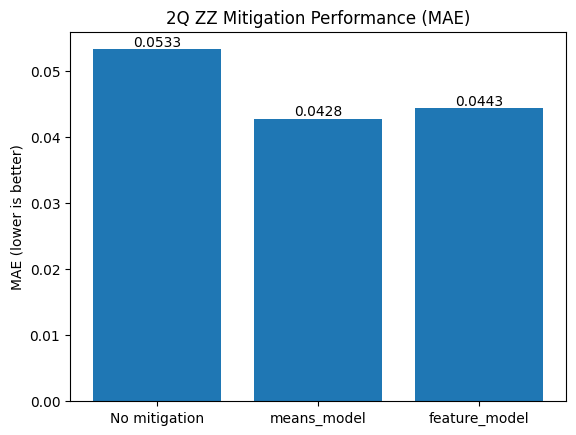

In [25]:
plot_mae_comparison(results, title="2Q ZZ Mitigation Performance (MAE)")